In [5]:
import pandas as pd
import numpy as np
from numpy import dtype
import BreakageClassifier.code.classification.webpage_models as models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib
from collections import namedtuple
import os
import json
from importlib import reload
from sklearn import clone


from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)


from random import randint
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE

from BreakageClassifier.code.classification.dataset import Dataset, Datasets

import pickle


# setup
SESSION = 'session-35'

OUT_DIR = Path("./classify-out") / SESSION

os.makedirs(OUT_DIR, exist_ok=True)

from BreakageClassifier.code.features import constants

importlib.reload(constants)

<module 'BreakageClassifier.code.features.constants' from '/home/saiid/summer22-SaiidHajj/BreakageClassifier/code/features/constants.py'>

# Data


## Loading the data

In [6]:
DATASETS = Datasets(
    Dataset("adguard-pos", Path("./features-out/adguard/adguard-21-23"), remove_empty_issues=True),
    Dataset("adguard-neg", Path("./features-out/adguard-neg"), remove_empty_issues=False),
)

# Select validation issues
def select_validation_issues(dataset_pos, dataset_neg, test_size=0.2, random_state=43):
    pos_issues = dataset_pos.raw.issue.unique()
    neg_issues = dataset_neg.raw.issue.unique()
    
    pos_issues_df = pd.DataFrame(pos_issues, columns=["issue"])
    neg_issues_df = pd.DataFrame(neg_issues, columns=["issue"])
    
    pos_issues_df["is_breaking"] = 1
    neg_issues_df["is_breaking"] = -1
    
    issues_df = pd.concat([pos_issues_df, neg_issues_df])
    
    issues_df = issues_df.sample(frac=1, random_state=random_state)
    
    train_issues, test_issues = train_test_split(issues_df, test_size=test_size, stratify=issues_df.is_breaking, random_state=random_state)

    return train_issues, test_issues

TRAIN_ISSUES, VALIDATION_ISSUES = select_validation_issues(DATASETS._list[0], DATASETS._list[1], test_size=0.4)
TRAIN_ISSUES.to_csv(OUT_DIR / "train-issues.csv", index=False)
VALIDATION_ISSUES.to_csv(OUT_DIR / "validation-issues.csv", index=False)


# def get_train_issues(dataset_pos, dataset_neg, validation_issues):
#     pos_issues = dataset_pos.raw.issue.unique()
#     neg_issues = dataset_neg.raw.issue.unique()
    
#     pos_issues_df = pd.DataFrame(pos_issues, columns=["issue"])
#     neg_issues_df = pd.DataFrame(neg_issues, columns=["issue"])
    
#     pos_issues_df["is_breaking"] = 1
#     neg_issues_df["is_breaking"] = -1
    
#     issues_df = pd.concat([pos_issues_df, neg_issues_df])
    
#     issues_df = issues_df.sample(frac=1, random_state=43)
    
#     train_issues = issues_df[~issues_df.issue.isin(validation_issues)]
    
#     return train_issues

# VALIDATION_ISSUES = pd.read_csv(OUT_DIR / "validation-issues.csv")
# TRAIN_ISSUES = get_train_issues(DATASETS._list[0], DATASETS._list[1], VALIDATION_ISSUES.issue.unique())
# TRAIN_ISSUES.to_csv(OUT_DIR / "train-issues.csv", index=False)

# print(f"Validation issues: {len(VALIDATION_ISSUES)}")

DATASETS = Datasets(
    Dataset("adguard-pos", Path("./features-out/adguard/adguard-21-23"), remove_empty_issues=True).drop_issues(VALIDATION_ISSUES.issue.unique()),
    Dataset("adguard-neg", Path("./features-out/adguard-neg"), remove_empty_issues=False).drop_issues(VALIDATION_ISSUES.issue.unique()),
)

with open(OUT_DIR / "datasets.json", "w") as f:
    json.dump([{"name": d.name, "path": str(d.features_fp)} for d in DATASETS._list], f)

Dataset summaries

In [3]:
for dataset in DATASETS:
    print(dataset.name)
    print(len(dataset.raw.issue.unique()))
    display(dataset.data.describe())
    print("===================================")

adguard-pos
207


,screen_size_present,n_salient_rem,keyword_raw_present,iframe_rem,n_req_rem,dn_err_in_int_tree,n_visible_add,oth_rem,oth_ed,d_pos_x,...,txt_add,dn_el_in_scr_tree,mean_degree,n_tree_add,n_tree_rem,dn_scr_in_el_tree,lt_rem,keyword_char_present,io_ed,n_req
count,4176.0,2610.000000,4176.0,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,...,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.0,4176.000000,4176.000000
mean,0.0,0.062835,0.0,0.083333,37.394397,0.027059,1.405412,0.844349,0.189655,-164.190928,...,0.955939,93.650144,1.062657,2.182232,4.536398,1.141523,1.394157,0.0,0.307950,37.089080
std,0.0,1.324026,0.0,0.375603,72.904005,0.278552,10.674416,18.769965,1.086421,600.112976,...,8.505073,764.228998,0.226972,7.550775,5.962045,4.749922,13.055031,0.0,2.556756,106.292202
min,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4993.883301,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.0,0.000000,0.0,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,6.000000
75%,0.0,0.000000,0.0,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.0,0.000000,39.000000
max,0.0,48.000000,0.0,10.000000,714.000000,6.000000,307.000000,1130.000000,33.000000,4182.000000,...,227.000000,9282.000000,4.500000,58.000000,26.000000,40.000000,525.000000,0.0,66.000000,1043.000000


adguard-neg
113


,screen_size_present,n_salient_rem,keyword_raw_present,iframe_rem,n_req_rem,dn_err_in_int_tree,n_visible_add,oth_rem,oth_ed,d_pos_x,...,txt_add,dn_el_in_scr_tree,mean_degree,n_tree_add,n_tree_rem,dn_scr_in_el_tree,lt_rem,keyword_char_present,io_ed,n_req
count,2589.0,2589.0,2589.0,2589.000000,2589.0,2589.0,2589.000000,2589.000000,2589.000000,2589.000000,...,2589.000000,2589.0,2589.000000,2589.000000,2589.000000,2589.0,2589.000000,2589.0,2589.000000,2589.0
mean,0.0,0.0,0.0,0.048281,0.0,0.0,0.391271,0.099652,0.045964,-103.029484,...,0.140981,0.0,1.030166,9.330630,19.033604,0.0,0.341445,0.0,0.011201,0.0
std,0.0,0.0,0.0,0.244700,0.0,0.0,2.287882,0.652628,2.162767,640.637978,...,1.660704,0.0,0.157279,18.684447,24.359953,0.0,5.270729,0.0,0.229807,0.0
min,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-1874.000000,...,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
25%,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
50%,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.000000,0.000000,10.000000,0.0,0.000000,0.0,0.000000,0.0
75%,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.000000,11.000000,27.000000,0.0,0.000000,0.0,0.000000,0.0
max,0.0,0.0,0.0,3.000000,0.0,0.0,65.000000,26.000000,110.000000,1874.000000,...,56.000000,0.0,2.500000,74.000000,76.000000,0.0,177.000000,0.0,10.000000,0.0


all
320


,screen_size_present,n_salient_rem,keyword_raw_present,iframe_rem,n_req_rem,dn_err_in_int_tree,n_visible_add,oth_rem,oth_ed,d_pos_x,...,txt_add,dn_el_in_scr_tree,mean_degree,n_tree_add,n_tree_rem,dn_scr_in_el_tree,lt_rem,keyword_char_present,io_ed,n_req
count,6765.0,5199.000000,6765.0,6765.000000,6765.000000,6765.000000,6765.000000,6765.000000,6765.000000,6765.000000,...,6765.000000,6765.000000,6765.000000,6765.000000,6765.000000,6765.000000,6765.000000,6765.0,6765.000000,6765.000000
mean,0.0,0.031545,0.0,0.069919,23.083370,0.016704,1.017295,0.559350,0.134664,-140.784132,...,0.644050,57.809756,1.050223,4.917960,10.084553,0.704656,0.991279,0.0,0.194383,22.894900
std,0.0,0.938553,0.0,0.332083,60.091709,0.219238,8.519145,14.756497,1.588430,616.607298,...,6.772065,602.136013,0.203744,13.447631,17.281326,3.772780,10.774478,0.0,2.018886,85.431849
min,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4993.883301,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.0,0.000000,0.0,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,12.000000,0.000000,0.000000,0.0,0.000000,17.000000
max,0.0,48.000000,0.0,10.000000,714.000000,6.000000,307.000000,1130.000000,110.000000,4182.000000,...,227.000000,9282.000000,4.500000,74.000000,76.000000,40.000000,525.000000,0.0,66.000000,1043.000000


## Exploratory Data Analysis

### label distributions
**Observations**: 
- high imbalance.
- minority class: Breaking edits. this is expected since we should see more correct edits from moderators in response to issues from breaking edits.
- majority class: Fixing edits. this is also expected since neutral edits mean the edit is ambiguous, this is an indicator that the subtree labeler is working as expected.

-1    3752
 0    1712
 1    1301
Name: is_breaking, dtype: int64
fixing     3752
broken     1712
neutral    1301
Name: is_breaking, dtype: int64


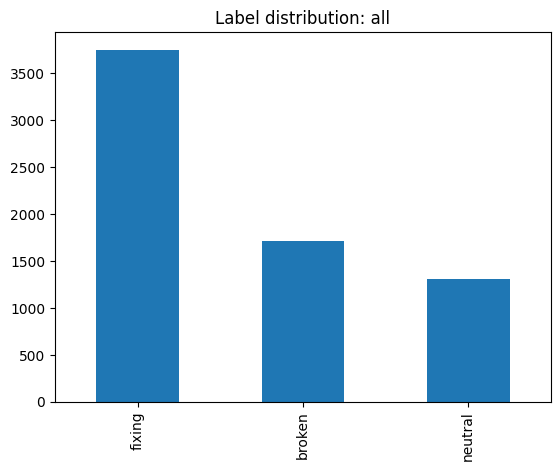

In [4]:
def plot_labels_count(df, name):
    counts_df = df.is_breaking.value_counts()
    print(counts_df)
    counts_df.index = ['fixing', 'broken', 'neutral']

    counts_df.plot.bar()
    print(counts_df)
    plt.title(f"Label distribution: {name}")
    plt.show()
    
# plot_labels_count(df_ublock, "Ublock")
# plot_labels_count(df_easylist, "Easylist")
# plot_labels_count(df_all, "Both")

plot_labels_count(DATASETS.all.data, dataset.name)


In [5]:
# ratios for issues
def print_ratios(df):
    print("Fixing ratio:", df[df.is_breaking == -1].shape[0] / df.shape[0])
    print("Neutral ratio:", df[df.is_breaking == 0].shape[0] / df.shape[0])
    print("Broken ratio:", df[df.is_breaking == 1].shape[0] / df.shape[0])
    print("Total:", df.shape[0])
    
    def ratios_for_group(_df):
        return {
            'fixing': _df[_df.is_breaking == -1].shape[0] / _df.shape[0],
            'neutral': _df[_df.is_breaking == 0].shape[0] / _df.shape[0],
            'broken': _df[_df.is_breaking == 1].shape[0] / _df.shape[0],
            'total': _df.shape[0]
        }
    
    out = df.groupby('issue').apply(ratios_for_group, ).apply(pd.Series)
    
    print(out.describe())
    
    
    
for dataset in DATASETS:
    print(dataset.name)
    print_ratios(dataset.raw)
    print("===================================")

adguard-pos
Fixing ratio: 0.4978448275862069
Neutral ratio: 0.19061302681992337
Broken ratio: 0.3115421455938697
Total: 4176
           fixing     neutral      broken       total
count  207.000000  207.000000  207.000000  207.000000
mean     0.507532    0.166855    0.325612   20.173913
std      0.169655    0.133160    0.131961   14.268871
min      0.000000    0.000000    0.027778    2.000000
25%      0.439904    0.058824    0.235294    8.000000
50%      0.500000    0.166667    0.333333   18.000000
75%      0.600000    0.232051    0.407670   28.000000
max      0.923077    0.805556    0.700000   72.000000
adguard-neg
Fixing ratio: 0.6461954422556971
Neutral ratio: 0.3538045577443028
Broken ratio: 0.0
Total: 2589
           fixing     neutral  broken       total
count  113.000000  113.000000   113.0  113.000000
mean     0.615600    0.384400     0.0   22.911504
std      0.288419    0.288419     0.0   37.324962
min      0.000000    0.000000     0.0    1.000000
25%      0.500000    0.224490 

### Numerical Feature Distributions
**Observations**: 
- many features become zero.

#### Distribution of features and labels across experiments

In [5]:
def feature_dist_across_origins(dataset: Dataset, label, feature_index):
    
    df = dataset.raw
    df = df[df.is_breaking == label]
    features = dataset.features
    
    groupby = df.groupby(['origin', 'flipped'])[features]
    groups = list(groupby.indices.keys())
    n_features =  len(features)
    n_labels = len(groups)

    fig, axes = plt.subplots(1, n_labels + 1, )
    # fig.tight_layout()
    feature = features[feature_index]
    # for i, feature in enumerate(features):
    for j, group in enumerate(groups):
        
        data = groupby.get_group(group)[feature]
        axes[ j].set_title(f"{group} * {label}")
        axes[ j].set_ylabel(feature)
        
        try:
            data.plot.hist(ax=axes[ j])
        except:
            data.value_counts().plot.bar(ax=axes[j])
            
    fig.suptitle(feature)
        
    
# F = 9
    
# for dataset in DATASETS:
#     feature_dist_across_origins(dataset, -1, F)
#     feature_dist_across_origins(dataset, 1, F)
#     feature_dist_across_origins(dataset, 0, F)

### Categorical features: none detected

In [6]:
def get_categorical_features(df):
    # categorical features
    cat_cols = df.dtypes[df.dtypes == object].keys()
    cat_cols = list(set(cat_cols) - {'is_breaking'})
    print("categorical columns: ", cat_cols)
    
    return cat_cols

_ = get_categorical_features(DATASETS._list[0].data)

categorical columns:  []


In [7]:
# constant features
def get_constant_features(df):
    const_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            const_cols.append(col)
    print("constant columns: ", const_cols)
    print("non constant columns: ", set(df.columns) - set(const_cols))
    return const_cols

COLUMNS_INCLUDED = set(DATASETS.features)
CONSTANT_COLUMNS = set(get_constant_features(DATASETS.all.data))
COLUMNS_INCLUDED = COLUMNS_INCLUDED - CONSTANT_COLUMNS - {'is_breaking', 'issue'}

constant columns:  ['screen_size_present', 'keyword_raw_present', 'oth_no', 'scr_rem', 'base_domain_in_query', 'ad_size_in_qs_present', 'n_el_in_scr_tree', 'txt_no', 'dn_err_in_scr_tree', 'io_no', 'scr_add', 'dn_req_in_scr_tree', 'lt_no', 'scr_no', 'n_sal_tree_add', 'num_id_in_param_field', 'num_url_params', 'num_id_in_query_field', 'ad_size_present', 'semicolon_in_query', 'num_url_queries', 'keyword_char_present']
non constant columns:  {'n_salient_rem', 'n_req_in_scr_tree', 'iframe_no', 'n_sal_tree_rem', 'n_scr_err_add', 'is_third_party', 'pos_x', 'n_salient_add', 'added', 'removed', 'txt_ed', 'n_salient_ed', 'n_salient', 'num_requests', 'n_visible', 'is_breaking', 'io_add', 'n_visible_rem', 'lt_add', 'n_scr_in_el_tree', 'n_scr_add', 'iframe_rem', 'n_req_add', 'dn_salient_covered', 'n_req_rem', 'txt_rem', 'lt_ed', 'dn_err_in_int_tree', 'tree_height', 'n_visible_add', 'edited', 'oth_rem', 'txt_add', 'oth_ed', 'd_pos_x', 'n_int_in_tree', 'oth_add', 'dn_el_in_scr_tree', 'n_tree_edit', '

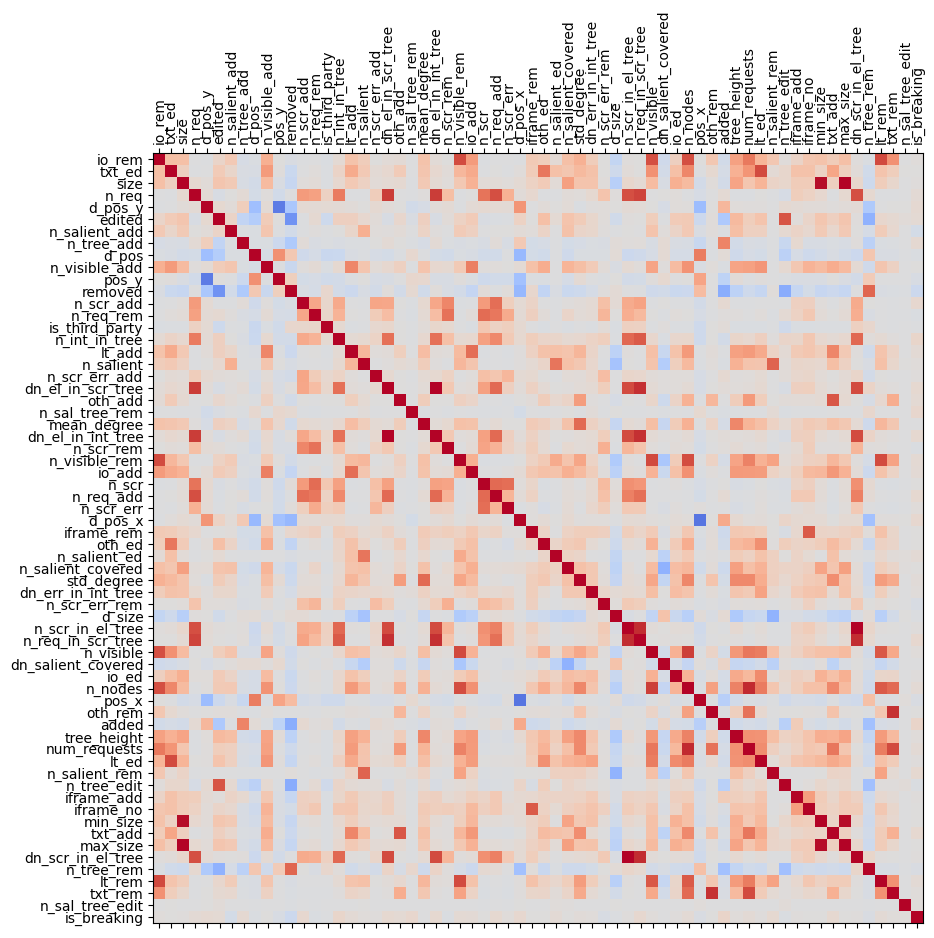

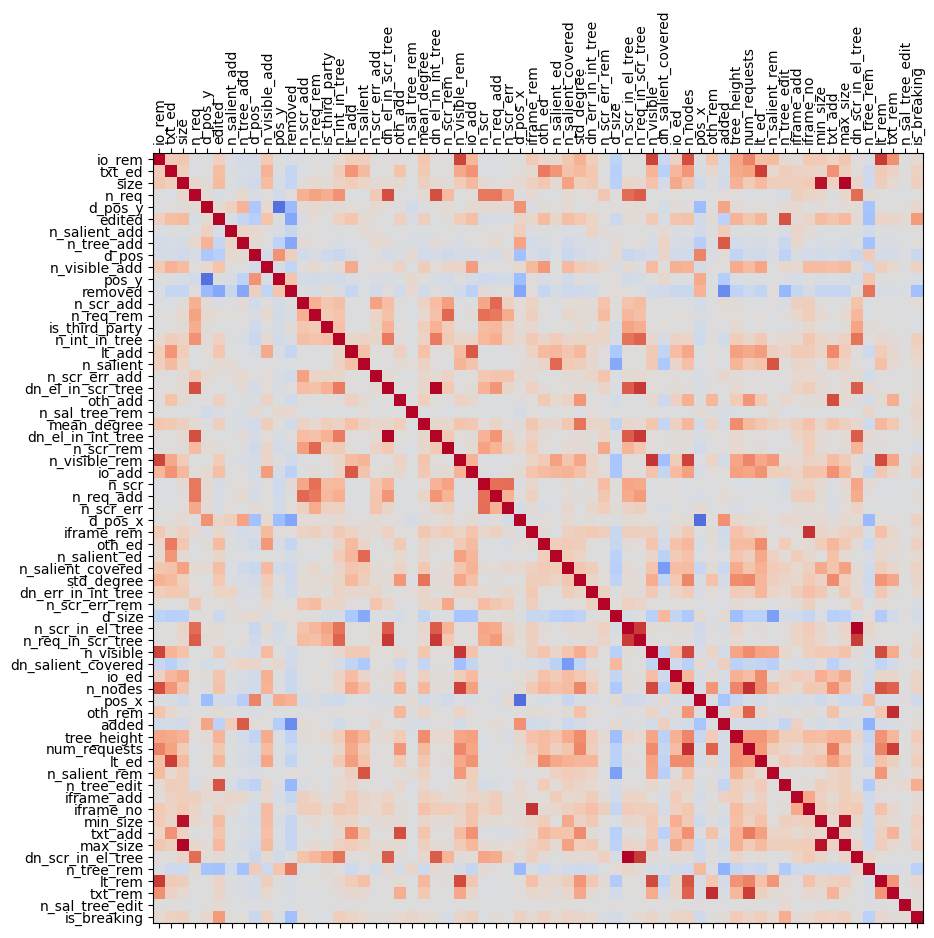

In [7]:
# correlation
def get_correlation(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()
    
    return corr

_df = DATASETS._list[0].data[~((DATASETS._list[0].raw.origin == "no_fixed") & (DATASETS._list[0].raw.edited == 1)) ]
_df = _df[_df.n_nodes > 1]

_ = get_correlation(DATASETS._list[0].data[list(COLUMNS_INCLUDED) + ['is_breaking']])
_ = get_correlation(_df[list(COLUMNS_INCLUDED) + ['is_breaking']])

# issues = DATASETS._list[0].data.issue.unique()

# N_ISSUES = 10

# SECTION = 12

# _data = DATASETS._list[0].data[DATASETS._list[0].data.issue.isin(issues[N_ISSUES * SECTION : N_ISSUES*(SECTION+1)])]


[False]


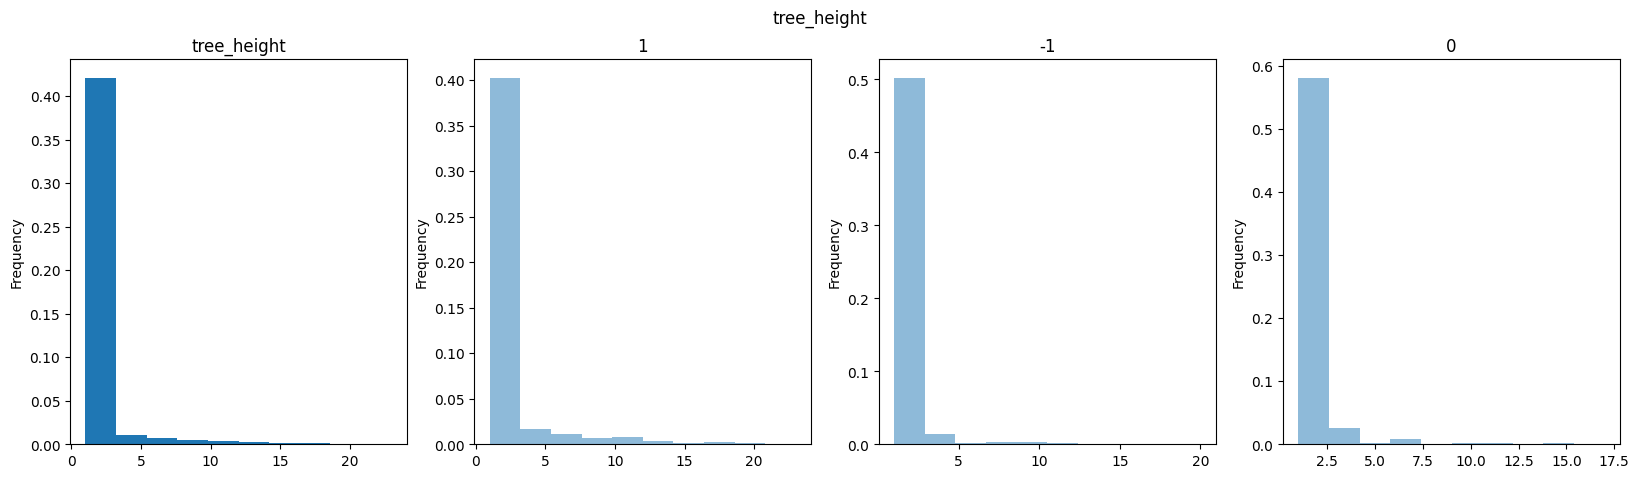

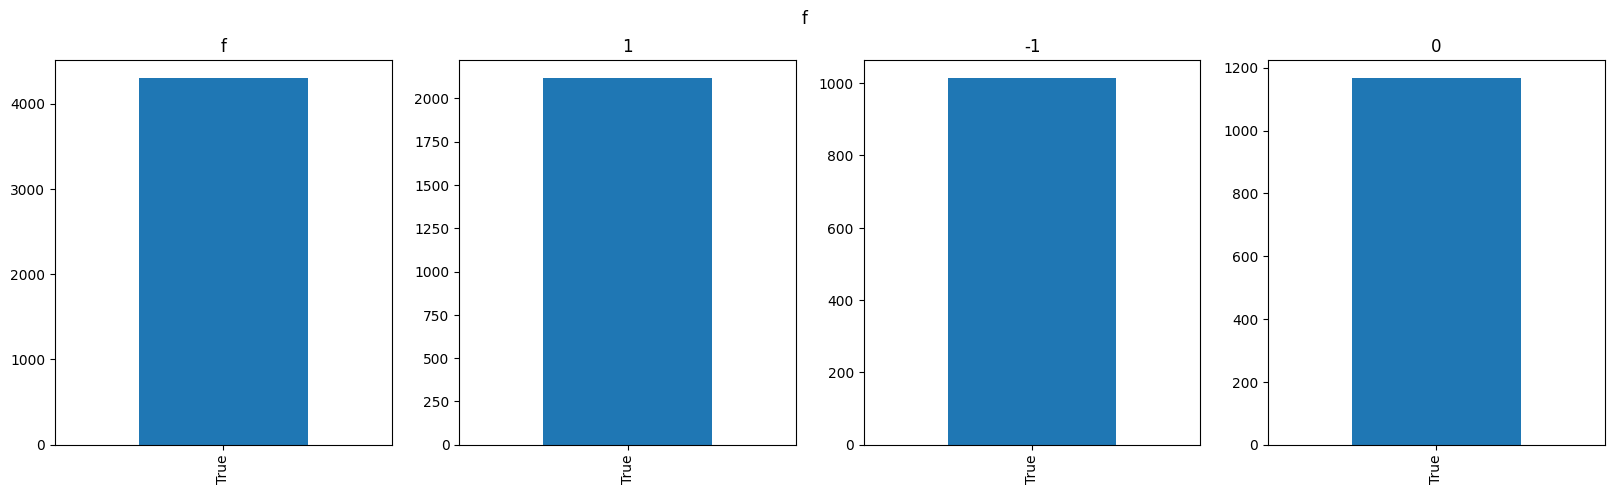

In [9]:
# feature distribution
def feature_distribution(df, feature):
    
    labels = df.is_breaking.unique()
    
    plt.figure(figsize=(20, 5))
    # plot distribution
    plt.subplot(1, len(labels) + 1, 1)
    
    if df[feature].dtype == object or df[feature].nunique() < 10:
        df[feature].value_counts().plot.bar()
    else:
        df[feature].plot.hist(density=True)
    plt.title(feature)
    
    # plot distribution grouped by `is_breaking` normalized
        
    for i, label in enumerate(labels):
        plt.subplot(1, len(labels) + 1, i + 2)
        plt.title(label)
        
        if df[feature].dtype == object or df[feature].nunique() < 10:
            df[df.is_breaking == label][feature].value_counts().plot.bar()
        else:
            df[df.is_breaking == label][feature].plot.hist(density=True, alpha=0.5, label=label)
    
    plt.suptitle(feature)
    plt.show()
    
    
feat = list(COLUMNS_INCLUDED)[0]
_df = DATASETS._list[0].raw.copy()
_df = _df[~((_df.origin == "no_fixed") & (_df.is_breaking == -1))]
print(_df[_df.is_breaking == -1].edited.unique())
feature_distribution(_df, feat)

thresholded_df = pd.DataFrame({
    'f': _df[feat] > 0,
    'is_breaking': _df.is_breaking
})

feature_distribution(thresholded_df, 'f' )


### outliers
- n_tree_edit > 20

### observation
- label added perfectly correlated with label `neutral`
- subtree edited also perfectly correlated with label `neutral`. also `broken` are more likely to have subtree edited
- subtree removed also good predictor
- `n_tree_add` also perfectly correlated with label `neutral`
- useless: `n_scr_add`
- maybe try to quantize and see if it helps:
    -  `> 0` for : 
    - `> 1` for : num_requests

### questions
- why n_visible is almost 0?
- is third party as a ratio is maybe bad. we need to create a new variable which is  bool = > 0
- why is the saliency feature so low




# Classifier

## Preprocessing functions
- getting the feature columns
- train/test splitting 10% 
- scaling
- oversampling
- undersampling
- preparing seperate train/test for cross-classification

In [8]:

# prep data and other functions
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import KFold

from BreakageClassifier.code.classification.webpage_models import Preprocessor

feature_cols = list(set(DATASETS.features) - {'is_breaking', 'issue'} - set(CONSTANT_COLUMNS))


def split_data(df, features=feature_cols, test_size=0.2, random_state=42):
    breaking_issues = []
    
    for issue in df.issue.unique():
        breaking_counts = df[df.issue == issue].is_breaking.value_counts()
    
        if 1 in breaking_counts.index and 0< breaking_counts[1]:
            breaking_issues.append(issue)
            
    _df=df[df.issue.isin(breaking_issues)]
    _df = _df[_df.n_nodes > 1]
    
    X = _df.loc[:, features].values
    y = _df.loc[:, 'is_breaking'].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    yield X_train, X_test, y_train, y_test, None, None

def split_data_by_issue(df, features=feature_cols, test_size=0.2, random_state=42):
    
    _df = df
    # _df = df[df.n_nodes > 1]
    
    issues = _df.issue.unique()
    
    train_issues, test_issues = train_test_split(
        issues, test_size=test_size,
        random_state=random_state
    )
    
    train_df = _df[_df.issue.isin(train_issues)]
    test_df = _df[_df.issue.isin(test_issues)]
    
    X_train, y_train = train_df.loc[:, features].values, train_df.loc[:, 'is_breaking'].values
    X_test, y_test = test_df.loc[:, features].values, test_df.loc[:, 'is_breaking'].values
    
    yield X_train, X_test, y_train, y_test, train_issues, test_issues


def k_fold_issues(df, features=feature_cols, n_splits=5, random_state=42):
    
    issues = df.issue.unique()
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_issue_indeces, test_issues_indeces in kf.split(issues):
        
        train_issues = issues[train_issue_indeces]
        test_issues = issues[test_issues_indeces]
        
        train_df = df[df.issue.isin(train_issues)]
        test_df = df[df.issue.isin(test_issues)]
    
        X_train, y_train = train_df.loc[:, features].values, train_df.loc[:, 'is_breaking'].values
        X_test, y_test = test_df.loc[:, features].values, test_df.loc[:, 'is_breaking'].values
        
        yield X_train, X_test, y_train, y_test, train_issues, test_issues


def prepare(
    data: pd.DataFrame,
    features: list = feature_cols,
    test_size=0.2,
    resampler=SMOTE, 
    scaler=StandardScaler,
    split_by=split_data,
    random_state=42, 
    encode_labels=True,
):
    
    # augment features with thresholded features
    
    preprocessor = Preprocessor(features=features)
    _data = preprocessor.fit_transform(data)
            
    
    X_train, X_test, y_train, y_test = split_by(_data, preprocessor.features, test_size, random_state)

    if encode_labels:
        lb = LabelEncoder()
        y_train = lb.fit_transform(y_train)
        y_test = lb.transform(y_test)
    
    # impute nans
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())
    
    if resampler:
        # resample
        ros = resampler(random_state=random_state)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        
    # scale
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, { str(a): str(i) for i, a in enumerate(lb.classes_) }, preprocessor


## Evaluation functions
- defining data sources
    - UBLOCK
    - EASYLIST
    - ALL: Concatenating both UBLOCK and EASYLIST in configs 0 - 5 and Concatenating UBLOCK and 50% of EASYLIST for training and only the other 50% of EASYLIST for testing for configs 7-11
- defining experiments on features
    - cross training: train using UBLOCK and test on EASYLIST
    - adding/removing saliency
    - adding/removing global features
    - changing subtree size (normal, one node, full tree)
- configurations on training methods
    - removing neutral subtree
    - oversampling
    - undersampling
- processing classification report to dataframe
- writing metrics to CSV files for analysis and presentation

## Experiments

In [9]:
from numpy import average
from xgboost import XGBClassifier

def eval_pretrained_pipeline(
    pipeline: models.ModelPipeline,
    data: pd.DataFrame,
    to_console=True,
):
    y_pred = pipeline.predict(data)
    y_val = data.is_breaking
    
    return eval_predictions(y_val, y_pred, to_console=to_console, batch=None, test_issues=None)


def eval_predictions(y_val, y_pred, to_console=True, batch=None, test_issues=None):
    auc = accuracy_score(y_val, y_pred)
    
    if to_console:
        print(classification_report(y_val, y_pred))
        print(f"AUC score: {auc}")
        
    clf_rep = classification_report(y_val, y_pred, output_dict=True)
        
    return  {
        "batch": batch,
        "test_issues": test_issues,
        "AUC": auc,
        "Accuracy": clf_rep['accuracy'],
        "+ve Precision": clf_rep.get('1', {}).get('precision', 0),
        "+ve Recall": clf_rep.get('1', {}).get('recall', 0),
        "-ve Precision": clf_rep.get('-1', {}).get('precision', 0),
        "-ve Recall": clf_rep.get('-1', {}).get('recall', 0)
    }
    

def eval_pipeline(
    pipeline: models.ModelPipeline,
    data: pd.DataFrame,
    split_by=split_data_by_issue,
    resampler=SMOTE,
    random_state=None,
    fimp=True,
    to_console=True,    
):
    
    results = []
    std_results = {
        "AUC": 0,
        "Accuracy": 0,
        "+ve Precision": 0,
        "+ve Recall": 0,
        "-ve Precision": 0,
        "-ve Recall": 0
    }
    average_results = {
        "batch": "average",
        "test_issues": None,
        "AUC": 0,
        "Accuracy": 0,
        "+ve Precision": 0,
        "+ve Recall": 0,
        "-ve Precision": 0,
        "-ve Recall": 0
    }

    
    for i, (y_val, y_pred, test_issues) in enumerate(pipeline.eval(data, split_by=split_by, resampler=resampler, random_state=random_state, verbose=to_console)):
        _results = eval_predictions(y_val, y_pred, to_console=to_console, batch=i, test_issues=test_issues)
        
        results.append(_results)
        
        average_results['AUC'] += _results['AUC']
        average_results['Accuracy'] += _results['Accuracy']
        average_results['+ve Precision'] += _results['+ve Precision']
        average_results['+ve Recall'] += _results['+ve Recall']
        average_results['-ve Precision'] += _results['-ve Precision']
        average_results['-ve Recall'] += _results['-ve Recall']



    average_results['AUC'] /= len(results)
    average_results['Accuracy'] /= len(results)
    average_results['+ve Precision'] /= len(results)
    average_results['+ve Recall'] /= len(results)
    average_results['-ve Precision'] /= len(results)
    average_results['-ve Recall'] /= len(results)
    
    # compute std
    for _results in results:
        std_results['AUC'] += (_results['AUC'] - average_results['AUC']) ** 2
        std_results['Accuracy'] += (_results['Accuracy'] - average_results['Accuracy']) ** 2
        std_results['+ve Precision'] += (_results['+ve Precision'] - average_results['+ve Precision']) ** 2
        std_results['+ve Recall'] += (_results['+ve Recall'] - average_results['+ve Recall']) ** 2
        std_results['-ve Precision'] += (_results['-ve Precision'] - average_results['-ve Precision']) ** 2
        std_results['-ve Recall'] += (_results['-ve Recall'] - average_results['-ve Recall']) ** 2
        
    std_results['AUC'] = np.sqrt(std_results['AUC'] / len(results))
    std_results['Accuracy'] = np.sqrt(std_results['Accuracy'] / len(results))
    std_results['+ve Precision'] = np.sqrt(std_results['+ve Precision'] / len(results))
    std_results['+ve Recall'] = np.sqrt(std_results['+ve Recall'] / len(results))
    std_results['-ve Precision'] = np.sqrt(std_results['-ve Precision'] / len(results))
    std_results['-ve Recall'] = np.sqrt(std_results['-ve Recall'] / len(results))
    
    results.append(std_results)
    results.append(average_results)

    return results, pipeline


def conf(model, dataset: Dataset, resampler=None, keep_neutral=True, fimp=True, features=None, title="", random_state=None):
    ## Configuration 1: Keep the neutral subtree class
    # print("Configuration: ", title)
    
    data= dataset.raw
    
    data = data[~((data.origin == "no_fixed") & (data.edited==True)) & (data.n_nodes > 1)].copy()
    
    if not keep_neutral:
        data = data[data.is_breaking != 0]
        
    if features:
        _features = list(set(data.columns) & set(features + ['is_breaking', 'issue']))
        data = data[_features]
        
    model_clone = clone(model) if not isinstance(model, XGBClassifier) else XGBClassifier(**model.get_params())
    
    return eval_pipeline(models.ModelPipeline(model_clone, models.Preprocessor(feature_cols)), data, split_by=k_fold_issues, resampler=resampler,fimp=fimp, random_state=random_state, to_console=False)


### Data-preprocessing
We are concerned that leakage might be occuring if we validate subtrees from issues where we train on.

In [11]:
confs = [
    ({
      'Resampling': '-',
      'Neutral class': '+',
      }, None, True),
    ({
       'Resampling': 'SMOTE',
    'Neutral class': '+', 
        }, SMOTE, True),
    ({
       'Resampling': 'Rand. Oversample',
    'Neutral class': '+', 
        }, RandomOverSampler, True),
    ({
       'Resampling': 'Rand. Undersample',
    'Neutral class': '+', 
        }, RandomUnderSampler, True),
    ({
        'Resampling': '-',
        'Neutral class': '-',
    }, None, False),
    ({
        'Resampling': 'SMOTE',
        'Neutral class': '-',
    }, SMOTE, False),
    ({
        'Resampling': 'Rand. Oversample',
        'Neutral class': '-',
    }, RandomOverSampler, False),
    ({
        'Resampling': 'Rand. Undersample',
        'Neutral class': '-',
    }, RandomUnderSampler, False),
]

classifiers = [
    ("XG-boost", XGBClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("SVM", SVC()),
    ("Naive Bayes", GaussianNB()),
    # ("MLP", MLPClassifier(
    #     max_iter=1000,
    #     hidden_layer_sizes=(100, 100, 100),
    #     activation='relu',
    #     solver='adam',
    #     verbose=False,
    # ))
    ]


EXPERIMENT = 'all-features-split-by-issue'

best_score = 0
best_model = None

reports = []
stds = []

for clf_name, clf in classifiers:
    
    for i, (conf_attrs, *conf_opts) in enumerate(confs):
        results, model = conf(clf, DATASETS.all, *conf_opts, fimp=True, random_state=43)
        
        average_result = results[-1]
        std_result = results[-2]
        
        report_imp = {
            "model": clf_name,
            **conf_attrs,
            **results[-1] # average results
        }
        
        reports.append(report_imp)
        stds.append(std_result)
        
        if report_imp['AUC'] > best_score:
            best_score = report_imp['AUC']
            best_model = model
            
# pd.concat(reports).to_csv(OUT_DIR / f"metrics={EXPERIMENT}={dataset.name}.csv", index=False)
import pickle

stds_df = pd.DataFrame(stds)

pickle.dump(best_model, open(OUT_DIR / f"best-xgb.pkl", "wb"))
print(pd.DataFrame(reports).to_latex(
    index=False, 
    float_format="%.2f", 
    na_rep="-", 
    escape=False, 
    column_format="lcccc", 
    caption="Performance of the different classifiers on the test set of issues.")
      )

print("MAX STD:", stds_df.values.max())
print("MEAN STD:", stds_df.values.mean())
print("MIN STD:", stds_df.values.min())
print("STD STD:", stds_df.values.std())

STD: test_issues           NaN
AUC              0.034499
Accuracy         0.034499
+ve Precision    0.080194
+ve Recall       0.072566
-ve Precision    0.039606
-ve Recall       0.043035
dtype: float64 +/- test_issues           NaN
AUC              0.006262
Accuracy         0.006262
+ve Precision    0.022224
+ve Recall       0.020839
-ve Precision    0.007100
-ve Recall       0.021441
dtype: float64
\begin{table}
\centering
\caption{Performance of the different classifiers on the test set of issues.}
\begin{tabular}{lcccc}
\toprule
        model &        Resampling & Neutral class &   batch & test_issues &   AUC &  Accuracy &  +ve Precision &  +ve Recall &  -ve Precision &  -ve Recall \\
\midrule
     XG-boost &                 - &             + & average &        None & 0.858 &     0.858 &          0.719 &       0.522 &          0.828 &       0.916 \\
     XG-boost &             SMOTE &             + & average &        None & 0.840 &     0.840 &          0.630 &       0.612 &         

/tmp/ipykernel_2471544/433157908.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("STD:", stds_df.mean(),"+/-", stds_df.std())
/tmp/ipykernel_2471544/433157908.py:87: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(reports).to_latex(


## Feature Importance

In [10]:
from enum import Enum


class SCOPE_TAG(Enum):
    SUBTREE = "subtree"
    GLOBAL = "global"
    
class CATEGORY_TAG(Enum):
    STRUCTURAL = "structural"
    CONTENT = "content"
    VISUAL = "visual"
    FUNCTIONAL = "functional"
    
class CRAWL_TAG(Enum):
    SALIENCY = "saliency"     
    INTERACTION = "interaction"
    ERROR = "error"
    
class BREAKAGE_TAG(Enum):
    NETWORK = "network"
    COSMETIC = "cosmetic"
    


FEATURE_TAGS = {
    "edited":                 [SCOPE_TAG.SUBTREE],
    "added":                  [SCOPE_TAG.SUBTREE],
    "removed":                [SCOPE_TAG.SUBTREE],
    "num_requests":           [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, BREAKAGE_TAG.NETWORK],
    "n_nodes":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.STRUCTURAL],
    "tree_height":            [SCOPE_TAG.SUBTREE, CATEGORY_TAG.STRUCTURAL],
    "mean_degree":            [SCOPE_TAG.SUBTREE, CATEGORY_TAG.STRUCTURAL],
    "std_degree":             [SCOPE_TAG.SUBTREE, CATEGORY_TAG.STRUCTURAL],
    "n_salient":              [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "n_salient_rem":          [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "n_salient_add":          [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "n_salient_ed":           [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "max_size":               [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "min_size":               [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "size":                   [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "d_size":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "pos_x":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "pos_y":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "d_pos_x":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "d_pos_y":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "d_pos":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "n_salient_covered":      [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY, BREAKAGE_TAG.COSMETIC],
    "n_salient_covered_rem":  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY, BREAKAGE_TAG.COSMETIC],
    "n_salient_covered_add":  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY, BREAKAGE_TAG.COSMETIC],
    "is_third_party":         [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "lt_add":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "lt_rem":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "lt_ed":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "lt_no":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "txt_add":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "txt_rem":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "txt_ed":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "txt_no":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "io_add":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "io_rem":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "io_ed":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "io_no":                  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "oth_add":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "oth_rem":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "oth_ed":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "oth_no":                 [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "scr_add":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "scr_rem":                [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "iframe_add":             [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "iframe_rem":             [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "iframe_no":              [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT],
    "num_url_queries":        [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "num_id_in_query_field":  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "num_url_params":         [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "num_id_in_param_field":  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "base_domain_in_query":   [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "semicolon_in_query":     [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "screen_size_present":    [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "ad_size_present":        [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "ad_size_in_qs_present":  [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "keyword_raw_present":    [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "keyword_char_present":   [SCOPE_TAG.SUBTREE, CATEGORY_TAG.CONTENT, BREAKAGE_TAG.NETWORK],
    "n_el_in_scr_tree":       [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL],
    "dn_el_in_scr_tree":      [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL],
    "dn_err_in_scr_tree":     [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, CRAWL_TAG.ERROR],
    "n_scr_in_el_tree":       [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL],
    "dn_scr_in_el_tree":      [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL],
    "dn_err_in_int_tree":     [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, CRAWL_TAG.ERROR, CRAWL_TAG.INTERACTION],
    "dn_el_in_int_tree":      [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, CRAWL_TAG.INTERACTION],
    "n_int_in_tree":          [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, CRAWL_TAG.INTERACTION],
    'n_req_in_scr_tree':      [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, BREAKAGE_TAG.NETWORK],
    'dn_req_in_scr_tree':     [SCOPE_TAG.SUBTREE, CATEGORY_TAG.FUNCTIONAL, BREAKAGE_TAG.NETWORK],
    "n_tree_rem":             [SCOPE_TAG.GLOBAL, CATEGORY_TAG.STRUCTURAL],
    "n_tree_add":             [SCOPE_TAG.GLOBAL, CATEGORY_TAG.STRUCTURAL],
    "n_tree_edit":            [SCOPE_TAG.GLOBAL, CATEGORY_TAG.STRUCTURAL],
    "n_sal_tree_rem":         [SCOPE_TAG.GLOBAL, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "n_sal_tree_add":         [SCOPE_TAG.GLOBAL, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "n_sal_tree_edit":        [SCOPE_TAG.GLOBAL, CATEGORY_TAG.VISUAL, CRAWL_TAG.SALIENCY],
    "n_visible":              [SCOPE_TAG.GLOBAL, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "n_visible_rem":          [SCOPE_TAG.GLOBAL, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "n_visible_add":          [SCOPE_TAG.GLOBAL, CATEGORY_TAG.VISUAL, BREAKAGE_TAG.COSMETIC],
    "n_scr":                  [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL],
    "n_scr_rem":              [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL],
    "n_scr_add":              [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL],
    "n_scr_err":              [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL],
    "n_scr_err_add":          [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL, CRAWL_TAG.ERROR],
    "n_scr_err_rem":          [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL, CRAWL_TAG.ERROR],
    "n_req":                  [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL, BREAKAGE_TAG.NETWORK],
    "n_req_rem":              [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL, BREAKAGE_TAG.NETWORK],
    "n_req_add":              [SCOPE_TAG.GLOBAL, CATEGORY_TAG.FUNCTIONAL, BREAKAGE_TAG.NETWORK],
}

def get_features_by_tags(tags):
    features = []
    for feature, feature_tags in FEATURE_TAGS.items():
        if set(tags).issubset(feature_tags):
            features.append(feature)
    return features

def get_all_features_beside(*tags_or_list):
    
    f_rem = set()
    
    for tag in tags_or_list:
        if isinstance(tag, list):
            f_rem |= set(get_features_by_tags(tag))
        else:
            f_rem |= set(get_features_by_tags([tag]))
    
    return list(set(FEATURE_TAGS.keys()) - set(f_rem))


def to_latex(report, base_report):
    
    # change the metric values from X.XXX to X.XX (+/- X.XX) the difference from the base model
    report = report.copy()
    report['AUC'] = report['AUC'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['AUC']:.3f})")
    report['Accuracy'] = report['Accuracy'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['Accuracy']:.3f})")
    # report['Avg. Precision'] = report['Avg. Precision'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['Avg. Precision']:.3f})")
    # report['Avg. Recall'] = report['Avg. Recall'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['Avg. Recall']:.3f})")
    report['+ve Precision'] = report['+ve Precision'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['+ve Precision']:.3f})")
    report['+ve Recall'] = report['+ve Recall'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['+ve Recall']:.3f})")
    report['-ve Precision'] = report['-ve Precision'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['-ve Precision']:.3f})")
    report['-ve Recall'] = report['-ve Recall'].apply(lambda x: f"{x:.3f} ({x - base_report[-1]['-ve Recall']:.3f})")
    
    report.drop(columns=['test_issues', 'batch'], inplace=True)
    report.rename(columns={
        "features": "Feature category",
        "AUC": "AUC ($\Delta$)",
        "Accuracy": "Accuracy ($\Delta$)",
        "+ve Precision": "+ve Precision ($\Delta$)",
        "+ve Recall": "+ve Recall ($\Delta$)",
        "-ve Precision": "-ve Precision ($\Delta$)",
        "-ve Recall": "-ve Recall ($\Delta$)",
    }, inplace=True)
    

    print(report.to_latex(
        index=False, 
        float_format="%.3f", 
        na_rep="-", 
        escape=False, 
        column_format="lcccccc", 
        caption="Feature category ablation study."
          )
    )

### Feature Importance: Importance in each category

In [14]:
base_report, base_model = conf(XGBClassifier(random_state=43), DATASETS.all, fimp=False, resampler=SMOTE, title="Base", random_state=43, features=list(set(FEATURE_TAGS.keys())))

categories = [
    ("Structural", [CATEGORY_TAG.STRUCTURAL]),
    ("Visual", [CATEGORY_TAG.VISUAL]),
    ("Content", [CATEGORY_TAG.CONTENT]),
    ("Functional", [CATEGORY_TAG.FUNCTIONAL]),
    ("Global", [SCOPE_TAG.GLOBAL]),
]

reports = [
    {
        'features': "All features",
        **base_report[-1]
    }
]

# stds = []

for category_name, category in categories:
    
    features = get_features_by_tags(category)
    features_beside = get_all_features_beside(category)
    
    cat_report, model = conf(XGBClassifier(random_state=43), DATASETS.all, features=features_beside, fimp=False, resampler=SMOTE, title=category_name, random_state=43)
    
    reports.append(
        {
            'features': f"No {category_name}",
            **cat_report[-1]
        }
    )
    
    for feature in features:
        
        test_features = features_beside + [feature]
        
        report, model = conf(XGBClassifier(random_state=43), DATASETS.all, features=test_features, fimp=False, resampler=SMOTE, title=category_name, random_state=43)
    
        reports.append(
            {
                'features': f"No {category_name} except {feature}",
                **report[-1]
            }
        )
        
        # stds.append(report[-2])

        
to_latex(pd.DataFrame(reports), base_report)

# stds_df = pd.DataFrame(stds)
# print("MAX STD:", stds_df.values.max())
# print("MEAN STD:", stds_df.values.mean())
# print("MIN STD:", stds_df.values.min())
# print("STD STD:", stds_df.values.std())


\begin{table}
\centering
\caption{Feature category ablation study.}
\begin{tabular}{lcccccc}
\toprule
                       Feature category & AUC ($\Delta$) & Accuracy ($\Delta$) & +ve Precision ($\Delta$) & +ve Recall ($\Delta$) & -ve Precision ($\Delta$) & -ve Recall ($\Delta$) \\
\midrule
                           All features &  0.837 (0.000) &       0.837 (0.000) &            0.615 (0.000) &         0.621 (0.000) &            0.844 (0.000) &         0.834 (0.000) \\
                          No Structural &  0.850 (0.013) &       0.850 (0.013) &            0.650 (0.035) &         0.622 (0.001) &            0.852 (0.008) &         0.856 (0.022) \\
           No Structural except n_nodes &  0.843 (0.006) &       0.843 (0.006) &            0.628 (0.012) &         0.628 (0.007) &            0.850 (0.005) &         0.841 (0.007) \\
       No Structural except tree_height &  0.847 (0.010) &       0.847 (0.010) &            0.635 (0.020) &         0.637 (0.016) &            0.854 (0.0

/tmp/ipykernel_2471544/3727887295.py:158: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report.to_latex(


TypeError: '>=' not supported between instances of 'str' and 'NoneType'

In [11]:
LOW_PREDICTIVE_FEATURES = {
    CATEGORY_TAG.STRUCTURAL: ['n_nodes', "tree_height", "n_tree_rem", "n_tree_add", "n_tree_edit"],
    CATEGORY_TAG.VISUAL: ['d_pos_x', 'd_pos_y', 
                          'd_pos', 
                          'n_salient_add',
                          'max_size', 'min_size', 'd_size', 'pos_x','pos_y', 
                          'n_salient_covered', 
                          'n_sal_tree_rem', 
                          'n_sal_tree_add', 
                          'n_visible', 
                          'n_visible_rem', 
                          'n_visible_add'
                          ],
    CATEGORY_TAG.FUNCTIONAL: ['n_scr_err_add',]
}

ALL_LOW_PREDICTIVE_FEATURES = []

for category, features in LOW_PREDICTIVE_FEATURES.items():
    ALL_LOW_PREDICTIVE_FEATURES += features
    

### Feature Importance: Categories

In [17]:
# remove low predictive features
base_features = list(set(FEATURE_TAGS.keys()) - set(ALL_LOW_PREDICTIVE_FEATURES))

base_report, base_model = conf(XGBClassifier(random_state=43), DATASETS.all, fimp=False, resampler=SMOTE, title="Base", random_state=43, features=base_features)

confs = (
    ("Subtree Only", get_features_by_tags([SCOPE_TAG.SUBTREE])),
    ("Global Only", get_features_by_tags([SCOPE_TAG.GLOBAL])),
    ("No Structural", get_all_features_beside([CATEGORY_TAG.STRUCTURAL])),
    ("No Content", get_all_features_beside([CATEGORY_TAG.CONTENT])),
    ("No Visual", get_all_features_beside([CATEGORY_TAG.VISUAL])),
    ("No Functional", get_all_features_beside([CATEGORY_TAG.FUNCTIONAL])),
    ("No Saliency", get_all_features_beside([CRAWL_TAG.SALIENCY])),
    ("No Interaction", get_all_features_beside([CRAWL_TAG.INTERACTION])),
    ("No Error", get_all_features_beside([CRAWL_TAG.ERROR])),
    ("No Saliency+Interaction+Error", get_all_features_beside(CRAWL_TAG.SALIENCY, CRAWL_TAG.INTERACTION, CRAWL_TAG.ERROR)),
    ("Network Features Only", get_features_by_tags([BREAKAGE_TAG.NETWORK])),
    ("Cosmetic Features Only", get_features_by_tags([BREAKAGE_TAG.COSMETIC])),
)

reports = [{
    'features': "Base",
    **base_report[-1]
}
]

stds = []

for conf_name, features in confs:
    
    # rem bad features
    features = list(set(features) - set(ALL_LOW_PREDICTIVE_FEATURES))
    
    report, model = conf(XGBClassifier(random_state=43), DATASETS.all, features=features, fimp=False, resampler=SMOTE, title=conf_name, random_state=43)
    print(report[-1])
    reports.append(
        {
            'features': conf_name,
            **report[-1]
        }
    )
    stds.append(report[-2])
    
reports_df = pd.DataFrame(reports)


to_latex(reports_df, base_report)

stds_df = pd.DataFrame(stds)

print("MAX STD:", stds_df.values.max())
print("MEAN STD:", stds_df.values.mean())
print("MIN STD:", stds_df.values.min())
print("STD STD:", stds_df.values.std())

{'batch': 'average', 'test_issues': None, 'AUC': 0.8371435827316821, 'Accuracy': 0.8371435827316821, '+ve Precision': 0.6679181945784795, '+ve Recall': 0.48710080950278634, '-ve Precision': 0.8118385726203275, '-ve Recall': 0.8904558106158342}
{'batch': 'average', 'test_issues': None, 'AUC': 0.3584330904532839, 'Accuracy': 0.3584330904532839, '+ve Precision': 0.395855111711055, '+ve Recall': 0.4273121057009961, '-ve Precision': 0.45895914984888375, '-ve Recall': 0.20191562975743488}
{'batch': 'average', 'test_issues': None, 'AUC': 0.8490573784422697, 'Accuracy': 0.8490573784422697, '+ve Precision': 0.6478665270861945, '+ve Recall': 0.6118057183339347, '-ve Precision': 0.8464326875554784, '-ve Recall': 0.863074848676048}
{'batch': 'average', 'test_issues': None, 'AUC': 0.852316770335128, 'Accuracy': 0.852316770335128, '+ve Precision': 0.6664112695749014, '+ve Recall': 0.5991670514058988, '-ve Precision': 0.8441154251923464, '-ve Recall': 0.8750240194150312}
{'batch': 'average', 'test_is

/tmp/ipykernel_2471544/3727887295.py:158: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report.to_latex(


### Feature Specific

In [12]:
reports = []

features = list(set(FEATURE_TAGS.keys()) - set(ALL_LOW_PREDICTIVE_FEATURES))

base_report, base_model = conf(XGBClassifier(random_state=43), DATASETS.all, fimp=False, resampler=SMOTE, title="Base", random_state=43, features=features)

reports = [{
    'features': "Base",
    **base_report[-1]
}
]

stds = []

for feature in features:
    _features = list(set(features) - set([feature]))
    report, model = conf(XGBClassifier(random_state=43), DATASETS.all, features=_features, fimp=False, resampler=SMOTE, title=f"Remove {feature}", random_state=43)
    
    reports.append(
        {
            'features': feature,
            **report[-1]
        }
    )
    stds.append(report[-2])
    
reports_df = pd.DataFrame(reports)

to_latex(reports_df, base_report)

stds_df = pd.DataFrame(stds)

print(stds_df)

print("MAX STD:", stds_df.values.max())
print("MEAN STD:", stds_df.values.mean())
print("MIN STD:", stds_df.values.min())
print("STD STD:", stds_df.values.std())

\begin{table}
\centering
\caption{Feature category ablation study.}
\begin{tabular}{lcccccc}
\toprule
     Feature category & AUC ($\Delta$) & Accuracy ($\Delta$) & +ve Precision ($\Delta$) & +ve Recall ($\Delta$) & -ve Precision ($\Delta$) & -ve Recall ($\Delta$) \\
\midrule
                 Base &  0.854 (0.000) &       0.854 (0.000) &            0.662 (0.000) &         0.619 (0.000) &            0.849 (0.000) &         0.872 (0.000) \\
  screen_size_present &  0.854 (0.000) &       0.854 (0.000) &            0.662 (0.000) &         0.619 (0.000) &            0.849 (0.000) &         0.872 (0.000) \\
        n_salient_rem &  0.859 (0.004) &       0.859 (0.004) &            0.675 (0.013) &         0.624 (0.004) &            0.852 (0.003) &         0.879 (0.008) \\
    n_req_in_scr_tree &  0.856 (0.002) &       0.856 (0.002) &            0.674 (0.013) &        0.602 (-0.017) &           0.845 (-0.004) &         0.885 (0.014) \\
            iframe_no &  0.855 (0.001) &       0.855 (0.001

/tmp/ipykernel_2511784/3727887295.py:158: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report.to_latex(


In [19]:
FEATURE_DESCRIPTION = {
    "edited":                 "Whether the subtree was edited",
    "added":                  "Whether the subtree was added",
    "removed":                "Whether the subtree was removed",
    "num_requests":           "Total \\# of requests called by elements in the subtree",
    "n_nodes":                "Total \\# of nodes in the subtree",
    "tree_height":            "Height of the subtree (also known as depth)",
    "mean_degree":            "Average degree of nodes in the subtree",
    "std_degree":             "Standard deviation of the degree of nodes in the subtree",
    "n_salient":              "Total \\# of salient elements in the subtree",
    "n_salient_rem":          "\\# of salient elements removed in the subtree after the filter rule edit",
    "n_salient_add":          "\\# of salient elements added in the subtree after the filter rule edit",
    "n_salient_ed":           "\\# of salient elements edited in the subtree after the filter rule edit",
    "max_size":               "Maximum size covered by the subtree on the page between the two visits",
    "min_size":               "Minimum size covered by the subtree on the page between the two visits",
    "size":                   "Size covered by the subtree on the page before the filter rule edit",
    "d_size":                 "$\\Delta$ in size covered by the subtree on the page after the filter rule edit",
    "pos_x":                  "Horizontal position of the subtree on the page before the filter rule edit",
    "pos_y":                  "Vertical position of the subtree on the page before the filter rule edit",
    "d_pos_x":                "$\\Delta$ in horizontal position of the subtree on the page after the filter rule edit",
    "d_pos_y":                "$\\Delta$ in vertical position of the subtree on the page after the filter rule edit",
    "d_pos":                  "$\\Delta$ in position of the subtree on the page after the filter rule edit (Euclidean distance)",
    "n_salient_covered":      "Total \\# of salient elements covered by the subtree on the page before the filter rule edit",
    "n_salient_covered_rem":  "\\# of salient elements covered by the subtree on the page removed after the filter rule edit",
    "n_salient_covered_add":  "\\# of salient elements covered by the subtree on the page added after the filter rule edit",
    "is_third_party":         "Whether the subtree contains elements from third party domains",
    "lt_add":                 "\\# of tags considered \\textit{Layout} added in the subtree after the filter rule edit",
    "lt_rem":                 "\\# of tags considered \\textit{Layout} removed in the subtree after the filter rule edit",
    "lt_ed":                  "\\# of tags considered \\textit{Layout} edited in the subtree after the filter rule edit",
    "lt_no":                  "Total \\# of tags considered \\textit{Layout} in the subtree before the filter rule edit",
    "txt_add":                "\\# of tags considered \\textit{Text} added in the subtree after the filter rule edit",
    "txt_rem":                "\\# of tags considered \\textit{Text} removed in the subtree after the filter rule edit",
    "txt_ed":                 "\\# of tags considered \\textit{Text} edited in the subtree after the filter rule edit",
    "txt_no":                 "Total \\# of tags considered \\textit{Text} in the subtree before the filter rule edit",
    "io_add":                 "\\# of tags considered \\textit{Input/Output} added in the subtree after the filter rule edit",
    "io_rem":                 "\\# of tags considered \\textit{Input/Output} removed in the subtree after the filter rule edit",
    "io_ed":                  "\\# of tags considered \\textit{Input/Output} edited in the subtree after the filter rule edit",
    "io_no":                  "Total \\# of tags considered \\textit{Input/Output} in the subtree before the filter rule edit",
    "oth_add":                "\\# of tags considered \\textit{Other} added in the subtree after the filter rule edit",
    "oth_rem":                "\\# of tags considered \\textit{Other} removed in the subtree after the filter rule edit",
    "oth_ed":                 "\\# of tags considered \\textit{Other} edited in the subtree after the filter rule edit",
    "oth_no":                 "Total \\# of tags considered \\textit{Other} in the subtree before the filter rule edit",
    "scr_add":                "\\# of \texttt{<script>} tags added in the subtree after the filter rule edit",
    "scr_rem":                "\\# of \texttt{<script>} tags removed in the subtree after the filter rule edit",
    "iframe_add":             "\\# of \texttt{<iframe>} tags added in the subtree after the filter rule edit",
    "iframe_rem":             "\\# of \texttt{<iframe>} tags removed in the subtree after the filter rule edit",
    "iframe_no":              "Total \\# of \texttt{<iframe>} tags in the subtree before the filter rule edit",
    "num_url_queries":        "Total \\# of URL queries in URLs called by elements in the subtree",
    "num_id_in_query_field":  "Total \\# of URL queries containing an ID in the query field",
    "num_url_params":         "Total \\# of URL parameters in URLs called by elements in the subtree",
    "num_id_in_param_field":  "Total \\# of URL parameters containing an ID in the parameter field",
    "base_domain_in_query":   "Whether the base domain of the URL is in the query field",
    "semicolon_in_query":     "Whether the query field contains a semicolon",
    "screen_size_present":    "Whether the screen size is present in the URL",
    "ad_size_present":        "Whether the ad size is present in the URL",
    "ad_size_in_qs_present":  "Whether the ad size is present in the query string",
    "keyword_raw_present":    "Whether the keyword is present in the URL",
    "keyword_char_present":   "Whether the keyword is present in the URL (character level)",
    "n_el_in_scr_tree":       "Total \\# of elements queried by a script related to the sub-tree.",
    "dn_el_in_scr_tree":      "$\\Delta$ in the total \\# of elements queried by a script related to the sub-tree.",
    "dn_err_in_scr_tree":     "$\\Delta$ in the total \\# of errors thrown by a script related to the sub-tree.",
    "n_scr_in_el_tree":       "Total \\# of scripts queried by an element in the sub-tree.",
    "dn_scr_in_el_tree":      "$\\Delta$ in the total \\# of scripts querying an element in the sub-tree.",
    "dn_err_in_int_tree":     "$\\Delta$ in the total \\# of errors after interactions with the sub-tree.",
    "dn_el_in_int_tree":      "$\\Delta$ in the total \\# of elements queried after interactions with the sub-tree.",
    "n_int_in_tree":          "Total \\# of interactions with the sub-tree.",
    'n_req_in_scr_tree':      "Total \\# of requests called by scripts related to the sub-tree.",
    'dn_req_in_scr_tree':     "$\\Delta$ in the total \\# of requests called by scripts related to the sub-tree.",
    "n_tree_rem":             "Total \\# of subtrees removed in the filter rule edit",
    "n_tree_add":             "Total \\# of subtrees added in the filter rule edit",
    "n_tree_edit":            "Total \\# of subtrees edited in the filter rule edit",
    "n_sal_tree_rem":         "Total \\# of salient subtrees removed in the filter rule edit",
    "n_sal_tree_add":         "Total \\# of salient subtrees added in the filter rule edit",
    "n_sal_tree_edit":        "Total \\# of salient subtrees edited in the filter rule edit",
    "n_visible":              "Total \\# of visible elements in the page",
    "n_visible_rem":          "Total \\# of visible elements removed in the filter rule edit",
    "n_visible_add":          "Total \\# of visible elements added in the filter rule edit",
    "n_scr":                  "Total \\# of scripts in the page",
    "n_scr_rem":              "Total \\# of scripts removed in the filter rule edit",
    "n_scr_add":              "Total \\# of scripts added in the filter rule edit",
    "n_scr_err":              "Total \\# of errors thrown by scripts in the page",
    "n_scr_err_add":          "Total \\# of errors thrown by scripts added in the filter rule edit",
    "n_scr_err_rem":          "Total \\# of errors thrown by scripts removed in the filter rule edit",
    "n_req":                  "Total \\# of requests in the page",
    "n_req_rem":              "Total \\# of requests removed in the filter rule edit",
    "n_req_add":              "Total \\# of requests added in the filter rule edit",
}

In [20]:
reports_df = reports_df.sort_values("AUC", ascending=True)
reports_df['tags'] = reports_df.features.apply(lambda x: FEATURE_TAGS.get(x, []))
reports_df['description'] = reports_df.features.apply(lambda x: FEATURE_DESCRIPTION.get(x, "N/A"))

def scope(tags):
    if SCOPE_TAG.SUBTREE in tags:
        return "Subtree"
    elif SCOPE_TAG.GLOBAL in tags:
        return "Global"
    else:
        return "N/A"
    
def category(tags):
    if CATEGORY_TAG.STRUCTURAL in tags:
        return "Structural"
    elif CATEGORY_TAG.VISUAL in tags:
        return "Visual"
    elif CATEGORY_TAG.CONTENT in tags:
        return "Content"
    elif CATEGORY_TAG.FUNCTIONAL in tags:
        return "Functional"
    else:
        return "N/A"
    
reports_df['scope'] = reports_df.tags.apply(scope)
reports_df['category'] = reports_df.tags.apply(category)
reports_df['AUC Loss'] = reports_df.AUC.apply(lambda x: f"{base_report[-1]['AUC']-x:.4f}")

# prevent long text from getting cut off
with pd.option_context("max_colwidth", 1000):

    print(reports_df.reset_index().drop(columns="index")[['AUC Loss', 'scope', 'category', 'description']].to_latex(
    float_format="%.5f", 
    na_rep="-", 
    escape=False, 
    column_format="lclll", 
    caption="Feature ablation study.",
    
    ))

\begin{table}
\centering
\caption{Feature ablation study.}
\begin{tabular}{lclll}
\toprule
{} & AUC Loss &    scope &    category &                                                                                    description \\
\midrule
0  &   0.0106 &   Global &  Functional &                                             Total \# of requests added in the filter rule edit \\
1  &   0.0091 &  Subtree &     Content &    \# of tags considered \textit{Input/Output} added in the subtree after the filter rule edit \\
2  &   0.0091 &  Subtree &  Structural &                                                         Average degree of nodes in the subtree \\
3  &   0.0071 &  Subtree &     Content &                 \# of \texttt{<iframe>} tags removed in the subtree after the filter rule edit \\
4  &   0.0063 &  Subtree &  Functional &              $\Delta$ in the total \# of elements queried by a script related to the sub-tree. \\
5  &   0.0063 &  Subtree &  Functional &             $\Delta$ in t

/tmp/ipykernel_2471544/3418954128.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(reports_df.reset_index().drop(columns="index")[['AUC Loss', 'scope', 'category', 'description']].to_latex(


## Model Selection

In [13]:
confs = [
    ({
      'Resampling': '-',
      'Neutral class': '+',
      }, None, True),
    ({
       'Resampling': 'SMOTE',
    'Neutral class': '+', 
        }, SMOTE, True),
    ({
       'Resampling': 'Rand. Oversample',
    'Neutral class': '+', 
        }, RandomOverSampler, True),
    ({
       'Resampling': 'Rand. Undersample',
    'Neutral class': '+', 
        }, RandomUnderSampler, True),
]

classifiers = [
    ("XG-boost", XGBClassifier(random_state=43)),
    ("Random Forest", RandomForestClassifier(random_state=43)),
    ("SVM", SVC(random_state=43)),
    ("Naive Bayes", GaussianNB()),
    ("MLP", MLPClassifier(
        max_iter=1000,
        hidden_layer_sizes=(100, 100, 100),
        activation='relu',
        solver='adam',
        verbose=False,
        random_state=43
    ))
    ]

best_model = None
best_score = 0

reports = []
stds = []

for clf_name, clf in classifiers:
    for i, (conf_attrs, *conf_opts) in enumerate(confs):
        results, model = conf(clf, DATASETS.all, *conf_opts, fimp=False, random_state=43, features = list(set(FEATURE_TAGS.keys()) - set(ALL_LOW_PREDICTIVE_FEATURES)))
        
        average_result = results[-1]
        
        report_imp = {
            "model": clf_name,
            **conf_attrs,
            **results[-1] # average results
        }
        
        print(report_imp)
        
        reports.append(report_imp)
        stds.append(results[-2])
        
        if report_imp['AUC'] > best_score:
            best_score = report_imp['AUC']
            best_model = model
                
print(pd.DataFrame(reports).drop(columns="Neutral class").to_latex(
    index=False, 
    float_format="%.2f", 
    na_rep="-", 
    escape=False, 
    column_format="lcccc", 
    caption="Performance of the different classifiers on the test set of issues.")
      )

stds_df = pd.DataFrame(stds)
print(stds_df)
print("MAX STD:", stds_df.values.max())
print("MEAN STD:", stds_df.values.mean())
print("MIN STD:", stds_df.values.min())
print("STD STD:", stds_df.values.std())

{'model': 'XG-boost', 'Resampling': '-', 'Neutral class': '+', 'batch': 'average', 'test_issues': None, 'AUC': 0.8574046858566712, 'Accuracy': 0.8574046858566712, '+ve Precision': 0.7460632846347133, '+ve Recall': 0.5165269965502783, '-ve Precision': 0.8245821832199226, '-ve Recall': 0.9156872259585389}
{'model': 'XG-boost', 'Resampling': 'SMOTE', 'Neutral class': '+', 'batch': 'average', 'test_issues': None, 'AUC': 0.8542477454186503, 'Accuracy': 0.8542477454186503, '+ve Precision': 0.6618617586339102, '+ve Recall': 0.6193335300425786, '-ve Precision': 0.8489107498416428, '-ve Recall': 0.871548386884647}
{'model': 'XG-boost', 'Resampling': 'Rand. Oversample', 'Neutral class': '+', 'batch': 'average', 'test_issues': None, 'AUC': 0.8491183422712408, 'Accuracy': 0.8491183422712408, '+ve Precision': 0.6766766633151537, '+ve Recall': 0.5980198562843498, '-ve Precision': 0.841044429011184, '-ve Recall': 0.8663235167965893}
{'model': 'XG-boost', 'Resampling': 'Rand. Undersample', 'Neutral cl

/tmp/ipykernel_2511784/784519858.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(reports).drop(columns="Neutral class").to_latex(


In [14]:
print(pd.DataFrame(reports).drop(columns=['batch', 'test_issues', 'Neutral class']).to_latex(
    index=False, 
    float_format="%.3f", 
    na_rep="-", 
    escape=False, 
    column_format="llcccccc", 
    caption="Performance of the different classifiers on the test set of issues.")
      )

\begin{table}
\centering
\caption{Performance of the different classifiers on the test set of issues.}
\begin{tabular}{llcccccc}
\toprule
        model &        Resampling &   AUC &  Accuracy &  +ve Precision &  +ve Recall &  -ve Precision &  -ve Recall \\
\midrule
     XG-boost &                 - & 0.867 &     0.867 &          0.800 &       0.577 &          0.828 &       0.931 \\
     XG-boost &             SMOTE & 0.863 &     0.863 &          0.745 &       0.629 &          0.840 &       0.902 \\
     XG-boost &  Rand. Oversample & 0.853 &     0.853 &          0.717 &       0.628 &          0.839 &       0.878 \\
     XG-boost & Rand. Undersample & 0.839 &     0.839 &          0.646 &       0.680 &          0.851 &       0.830 \\
Random Forest &                 - & 0.871 &     0.871 &          0.838 &       0.552 &          0.824 &       0.949 \\
Random Forest &             SMOTE & 0.850 &     0.850 &          0.688 &       0.659 &          0.846 &       0.863 \\
Random Forest &  Ran

/tmp/ipykernel_2873025/3287901688.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(reports).drop(columns=['batch', 'test_issues', 'Neutral class']).to_latex(


In [19]:
report, best_model = conf(XGBClassifier(random_state=43), DATASETS.all, fimp=False, resampler=SMOTE, title="", random_state=43, features=list(set(FEATURE_TAGS.keys()) - set(ALL_LOW_PREDICTIVE_FEATURES)))
pickle.dump(best_model, open(OUT_DIR / f"best-xgb.pkl", "wb"))

In [40]:
best_network_only_model = conf(XGBClassifier(random_state=43), DATASETS.all, fimp=False, resampler=SMOTE, title="", random_state=43, features=get_features_by_tags([BREAKAGE_TAG.NETWORK]))[1]

### Dynamic / Static Evaluation

In [37]:
breakage_type_adguard = pd.read_csv("forums-out/adguard/manual-breakage-type.csv")
static_issues = breakage_type_adguard[breakage_type_adguard['breakage-type'] == 'static'].id.unique()
dynamic_issues = breakage_type_adguard[breakage_type_adguard['breakage-type'] == 'dynamic'].id.unique()

In [38]:
static_data = DATASETS.all.raw[DATASETS.all.raw.issue.isin(static_issues)].copy()
dynamic_data = DATASETS.all.raw[DATASETS.all.raw.issue.isin(dynamic_issues)].copy()
validation_data = DATASETS.all.raw[DATASETS.all.raw.issue.isin(breakage_type_adguard.id.unique())].copy()

eval_pretrained_pipeline(best_model, static_data, "static")
eval_pretrained_pipeline(best_model, dynamic_data, "dynamic")

              precision    recall  f1-score   support

          -1       0.82      0.65      0.73       732
           0       1.00      1.00      1.00       272
           1       0.55      0.75      0.64       416

    accuracy                           0.75      1420
   macro avg       0.79      0.80      0.79      1420
weighted avg       0.78      0.75      0.75      1420

AUC score: 0.7485915492957746
              precision    recall  f1-score   support

          -1       0.77      0.60      0.68       267
           0       0.99      1.00      0.99        98
           1       0.49      0.68      0.57       148

    accuracy                           0.70       513
   macro avg       0.75      0.76      0.75       513
weighted avg       0.73      0.70      0.71       513

AUC score: 0.6998050682261209


{'batch': None,
 'test_issues': None,
 'AUC': 0.6998050682261209,
 'Accuracy': 0.6998050682261209,
 '+ve Precision': 0.4878048780487805,
 '+ve Recall': 0.6756756756756757,
 '-ve Precision': 0.7703349282296651,
 '-ve Recall': 0.602996254681648}

In [43]:
y_pred = best_model.predict(validation_data)
y_pred_network = best_network_only_model.predict(validation_data)
y_true = validation_data.is_breaking.values

In [52]:

validation_data[(y_true == 1) & (y_pred_network == 0) & (y_pred == 1)].issue.unique()

array([157392, 155130,  53401, 156209, 161056, 156752,  52051, 150480,
        53202, 150115, 158945, 152356, 157544, 140523, 151017])

# External Evaluation

In [30]:
ublock_dataset = Dataset("ublock", Path("features-out/ublock/ublock-final/"),)
ublock_dataset.raw.is_breaking.value_counts()

-1    1429
 0     816
 1     783
Name: is_breaking, dtype: int64

In [26]:
# get the reproducibility data
REPRODUCIBILITY= {
    "easylist": pd.read_csv("forums-out/easylist/manual-reproduce.csv"), 
    "ublock": pd.read_csv("forums-out/ublock/repr.csv"),
}

easylist_dataset = Dataset("easylist", Path("features-out/easylist/easylist-final/"), remove_empty_issues=True)
ublock_dataset = Dataset("ublock", Path("features-out/ublock/ublock-final/"), remove_empty_issues=True)

EXTERNAL_DATASETS = Datasets(
    easylist_dataset,
    ublock_dataset
)

# load best model
best_model = pickle.load(open("classify-out/session-34/best-xgb.pkl", "rb"))

EXPERIMENTS = (
    {
        "train": 0, 
        "reproducible": None,
    }, 
    {
        "train": 0, 
        "reproducible": True,
    }, 
    {
        "train": 0, 
        "reproducible": False,
    }, 
    {
        "train": 1, 
        "reproducible": True,
    }, 
    # {
    #     "train": 2, 
    #     "reproducible": True,
    # }, 
)

reports = []
stds = []

for dataset in EXTERNAL_DATASETS:
    
    if dataset.name == "all":
        continue
    
    for experiment in EXPERIMENTS:
        
        data = dataset.raw.copy()
        reproducible_issues = REPRODUCIBILITY[dataset.name]
        reproducible_issues = reproducible_issues[reproducible_issues.reproduce == 1].id
        
        if experiment['reproducible'] == True:
            data = data[data.issue.isin(reproducible_issues)]
        
        elif experiment['reproducible'] == False:
            data = data[~data.issue.isin(reproducible_issues)]
            
        if experiment['train'] == 1:
            model = best_model.model
            model_clone = clone(model) if not isinstance(model, XGBClassifier) else XGBClassifier(**model.get_params())
            _reports, _ = eval_pipeline(models.ModelPipeline(model_clone, models.Preprocessor(feature_cols)), data, split_by=k_fold_issues, resampler=SMOTE,fimp=False, random_state=43, to_console=False)
            report = _reports[-1]
            stds.append(_reports[-2])
            
        elif experiment['train'] == 2:
            
            validation_issues = data.issue.sample(frac=0.7, random_state=43)
            train_issues = data[~data.issue.isin(validation_issues)].issue
            
            train_data = pd.concat([data[data.issue.isin(train_issues)], DATASETS.all.raw])
            
            validation_data = data[data.issue.isin(validation_issues)]
            
            model = best_model.model
            model_clone = clone(model) if not isinstance(model, XGBClassifier) else XGBClassifier(**model.get_params())
            
            model_wrapper_clone = models.ModelPipeline(model_clone, models.Preprocessor(feature_cols))
            model_wrapper_clone.fit(train_data)
            
            report = eval_pretrained_pipeline(model_wrapper_clone, validation_data, to_console=False)
            
        else:
            report = eval_pretrained_pipeline(best_model, data, to_console=False)
    
        report |= {
                "dataset": dataset.name,
                "re-trained": experiment['train'],
                "reproducible": experiment['reproducible']
            }
        
        reports.append(report)
        
reports_df = pd.DataFrame(reports)

def to_latex(reports_df):

    _reports_df = reports_df.copy()
    _reports_df = _reports_df[['dataset', 're-trained', 'reproducible', 'AUC', 'Accuracy', '+ve Precision', '+ve Recall', '-ve Precision', '-ve Recall']]
    
    _reports_df['re-trained'] = _reports_df['re-trained'].apply(lambda x: "$\\times$" if x == False else "-" if x == None else "$\\checkmark$")
    _reports_df['reproducible'] = _reports_df['reproducible'].apply(lambda x: "$\\times$" if x == False else "-" if x == None else "$\\checkmark$")

    print(_reports_df.to_latex(
        index=False, 
        float_format="%.2f", 
        na_rep="-", 
        escape=False, 
        column_format="lccccccc",
        caption="Performance of the best classifier on the external datasets.")
        )
    
to_latex(reports_df)

stds_df = pd.DataFrame(stds)

print("MAX STD:", stds_df.values.max())
print("MEAN STD:", stds_df.values.mean())
print("MIN STD:", stds_df.values.min())
print("STD STD:", stds_df.values.std())


\begin{table}
\centering
\caption{Performance of the best classifier on the external datasets.}
\begin{tabular}{lccccccc}
\toprule
 dataset &   re-trained & reproducible &  AUC &  Accuracy &  +ve Precision &  +ve Recall &  -ve Precision &  -ve Recall \\
\midrule
easylist &     $\times$ &            - & 0.76 &      0.76 &           0.69 &        0.68 &           0.71 &        0.72 \\
easylist &     $\times$ & $\checkmark$ & 0.80 &      0.80 &           0.81 &        0.64 &           0.68 &        0.83 \\
easylist &     $\times$ &     $\times$ & 0.75 &      0.75 &           0.65 &        0.69 &           0.72 &        0.69 \\
easylist & $\checkmark$ & $\checkmark$ & 0.76 &      0.76 &           0.77 &        0.61 &           0.64 &        0.76 \\
  ublock &     $\times$ &            - & 0.84 &      0.84 &           0.85 &        0.77 &           0.77 &        0.85 \\
  ublock &     $\times$ & $\checkmark$ & 0.87 &      0.87 &           0.95 &        0.77 &           0.75 &        0.95 \\

/home/saiid/miniconda3/envs/openwpm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saiid/miniconda3/envs/openwpm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saiid/miniconda3/envs/openwpm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

# Visualizations and Examples

## Drawing the subtree

In [39]:
# prepare indexed subtrees
from BreakageClassifier.code.features import utils as futils
import BreakageClassifier.code.run as features
from importlib import reload

from pathlib import Path
import os
import pandas as pd
reload(futils)
reload(features)

# dynamic breakage of video
# VISUALIZE_ISSUE = 139618

# network insufficiency
VISUALIZE_ISSUE = 139618



In [ ]:
features.pipeline(
    # Path("./debug-crawl/out-debug"),
    Path("./crawl-out/adguard-full/"),
    Path("./features-out/adguard/adguard-debug-zero-broken/"),
    # edits_dir=Path("./features-out/adguard/adguard-debug-tree/"),
    issues= [str(VISUALIZE_ISSUE)],
)

In [17]:
import BreakageClassifier.code.features.utils as tree_utils
import pandas as pd
subtrees = pd.read_csv("./features-out/adguard/adguard-21/edits.csv")
subtrees = subtrees[subtrees.issue == 139618]
_, subtrees = tree_utils.index_subtrees(subtrees)

for _, root in subtrees[subtrees.is_root == True].iterrows():
        
        print("Origin:" , root.origin, root.flipped)
        print("Subtree Index:", root.subtree_index)
        print("Broken: ", root.is_breaking)
        subtree = tree_utils.get_subtree(subtrees, root)
        tree_utils.visualize_edit_tree(subtree, labeled=True)
        


DEBUG Indexing subtrees



100%|██████████| 47/47 [00:00<00:00, 972.56it/s]

INFO index_subtrees took 0.05 seconds

Origin: no_fixed False
Subtree Index: 0
Broken:  -1


[70=70] main  .siteMain.container...(edited)
├── [111=nan] div (-)
│   ├── [112=nan] img (-)
│   └── [113=nan] div (-)
│       ├── [114=nan] p (-)
│       │   ├── [115=nan] #text (-)
│       │   ├── [116=nan] #text (-)
│       │   ├── [117=nan] #text (-)
│       │   ├── [118=nan] #text (-)
│       │   └── [119=nan] #text (-)
│       └── [120=nan] button (-)
│           ├── [121=nan] #text (-)
│           └── [122=nan] #text (-)
├── [123=nan] section (-)
│   └── [124=nan] div (-)
├── [127=nan] section (-)
│   └── [128=nan] div (-)
│       ├── [129=nan] div (-)
│       │   └── [130=nan] div (-)
│       │       ├── [131=nan] img (-)
│       │       └── [132=nan] div (-)
│       │           ├── [133=nan] p (-)
│       │           │   ├── [134=nan] #text (-)
│       │           │   ├── [135=nan] #text (-)
│       │           │   ├── [136=nan] #text (-)
│       │           │   ├── [137=nan] #text (-)
│       │           │   └── [138=nan] #text (-)
│       │           └── [139=nan] button (-)

In [1]:
import BreakageClassifier.code.features.dom as tree_comp
from BreakageClassifier.code.features.utils import _parse_attrs
reload(tree_comp)
SUBTREE_ID = 4
subtree = subtrees[subtrees.subtree_index == SUBTREE_ID]

# display(subtree.drop_duplicates())

features = pd.read_csv("./features-out/adguard/adguard-debug-zero-broken/features.csv")

# print(features[features.subtree_index == SUBTREE_ID].iloc[0].prev_vc)
# display(features[features.subtree_index == SUBTREE_ID].iloc[0])

# display(subtree.prev_vc.iloc[0], subtree.new_vc.iloc[0])

node1 = subtrees[(subtrees.prev_id == "0b7ce810-a807-4f7a-a4d5-51244f2e19bf") & (subtrees.flipped==True)].iloc[0]
node2 = subtrees[(subtrees.prev_id == "0f8da782-234f-4b90-b740-402fe641e0e9") & (subtrees.flipped==False)].iloc[0]

prev_to_attr = {
    "prev_attr": "attributes",
    "prev_vc": "visual_cues",
    "prev_attr_id": "attr_id",
    "prev_attr_class": "attr_class",
    "prev_attr_src": "attr_src" 
}

new_to_attr = {
    "new_attr": "attributes",
    "new_vc": "visual_cues",
    "new_attr_id": "attr_id",
    "new_attr_class": "attr_class",
    "new_attr_src": "attr_src"
}

for key, attr in prev_to_attr.items():
    node1[attr] = node1[key] 

for key, attr in prev_to_attr.items():
    node2[attr] = node2[key]
    
tree_comp.score_similarity(node1, node2)

NameError: name 'reload' is not defined

In [18]:
import BreakageClassifier.code.run as features
from importlib import reload
from pathlib import Path
reload(features)

labels = {
    "no_fixed": ["visit_id_u", "visit_id_a"],
    "fixed_broken": ["visit_id_a", "visit_id_b"],
    "no_broken": ["visit_id_u", "visit_id_b"],
}

selected = "fixed_broken"

# output_edits = subtrees[subtrees.raw.origin == selected]

# display(output_edits)

features.debug(
    Path("./crawl-out/adguard-full/"),
    VISUALIZE_ISSUE,
    *labels[selected]
)

# output_edits = DATASETS._list[0].raw[ (DATASETS._list[0].raw.issue == VISUALIZE_ISSUE) & (DATASETS._list[0].raw.origin == selected)]

# futils.index_subtrees(subtrees)

INFO build_graph took 107.55 seconds

[0] body
├── [181] aside
├── [182] aside
│   └── [183] div
│       └── [184] div
│           └── [185] iframe
├── [186] script
│   └── [187] #text
├── [188] script
│   └── [189] #text
├── [190] script
│   └── [191] #text
├── [192] script
│   └── [193] #text
├── [194] script
│   └── [195] #text
├── [196] script
├── [197] iframe
├── [198] script
│   └── [199] #text
├── [1] div
├── [200] script
├── [201] script
│   └── [202] #text
├── [203] script
│   └── [204] #text
├── [205] iframe
├── [206] iframe
├── [207] iframe
├── [2] header
│   └── [3] div
│       └── [4] div
│           ├── [5] a
│           │   └── [6] span
│           │       └── [7] svg
│           ├── [61] section
│           │   └── [62] button
│           │       └── [63] span
│           ├── [64] section
│           │   └── [65] div
│           │       └── [66] button
│           │           └── [67] span
│           │               └── [68] svg
│           └── [9] nav
│               

,browser_id,visit_id,id,nodeName,type,attributes,visual_cues,parent_id,t_enter,t_leave,saliency,block,domain,top_level_domain,party,attr_id,attr_class,attr_src
73,4280149920,6880361256329307,73,img,1,"[{""key"": ""title"", ""value"": """"}, {""key"": ""src"",...","{""bounds"": {""x"": 333, ""y"": 72, ""width"": 1248, ...",72,142,145,1.0,74,None,futurezone.at,N/A,None,None,https://image.futurezone.at/images/cfs_landsca...
82,4280149920,6880361256329307,82,a,1,"[{""key"": ""href"", ""value"": ""https://futurezone....","{""bounds"": {""x"": 462.33331298828125, ""y"": 758,...",81,161,170,1.0,197,None,futurezone.at,N/A,None,tag,https://futurezone.at/digital-life
83,4280149920,6880361256329307,83,span,1,"[{""key"": ""class"", ""value"": ""icon icon-digitall...","{""bounds"": {""x"": 462.33331298828125, ""y"": 758,...",82,162,167,1.0,None,None,futurezone.at,N/A,None,icon icon-digitallife,None
84,4280149920,6880361256329307,84,svg,1,[],"{""bounds"": {""x"": 462.33331298828125, ""y"": 758,...",83,163,166,1.0,None,None,futurezone.at,N/A,None,None,None
86,4280149920,6880361256329307,86,#text,3,{},"{""bounds"": {""x"": 462.33331298828125, ""y"": 758,...",82,168,169,1.0,None,None,futurezone.at,N/A,None,None,None
87,4280149920,6880361256329307,87,h1,1,"[{""key"": ""class"", ""value"": ""article-header-tit...","{""bounds"": {""x"": 462.33331298828125, ""y"": 798,...",80,172,175,1.0,197,None,futurezone.at,N/A,None,article-header-title,None
88,4280149920,6880361256329307,88,#text,3,{},"{""bounds"": {""x"": 462.33331298828125, ""y"": 798,...",87,173,174,1.0,None,None,futurezone.at,N/A,None,None,None
97,4280149920,6880361256329307,97,p,1,[],"{""bounds"": {""x"": 649, ""y"": 902, ""width"": 510.6...",96,191,194,1.0,197,None,futurezone.at,N/A,None,None,None
98,4280149920,6880361256329307,98,#text,3,{},"{""bounds"": {""x"": 649, ""y"": 902, ""width"": 510.6...",97,192,193,1.0,None,None,futurezone.at,N/A,None,None,None
105,4280149920,6880361256329307,105,a,1,"[{""key"": ""target"", ""value"": ""_blank""}, {""key"":...","{""bounds"": {""x"": 446.33331298828125, ""y"": 1014...",104,203,220,1.0,193,None,futurezone.at,N/A,None,None,"https://bs.serving-sys.com/Serving/ad,Server.b..."


INFO process_differential_experiment took 1.66 seconds

DEBUG Indexing subtrees



100%|██████████| 24/24 [00:00<00:00, 794.89it/s]

[70=70] main  .siteMain.container...(edited)
├── [100=nan] div (-)
├── [101=nan] div (-)
├── [102=nan] div (-)
├── [103=nan] iframe (-)
├── [104=nan] div (-)
├── [105=nan] a [SALIENT] (-)
├── [106=nan] div [SALIENT] (-)
├── [107=nan] div [SALIENT] (-)
├── [108=nan] img [SALIENT] (-)
├── [109=nan] div [SALIENT] (-)
├── [110=nan] p [SALIENT] (-)
├── [111=nan] #text [SALIENT] (-)
├── [112=nan] h2 [SALIENT] (-)
├── [113=nan] #text [SALIENT] (-)
├── [124=nan] div  .ratio(-)
├── [125=nan] iframe (-)
├── [127=nan] div  .fuzoBox-content(-)
├── [128=nan] div  ._form_37(-)
├── [129=nan] div (-)
├── [130=nan] div  ._form_37(-)
├── [131=nan] span  .fuzoLine(-)
├── [132=nan] span  .fuzoLine-line(-)
├── [134=126] div  .item-1-1(edited)
├── [135=nan] section  .fuzoBox.fuzoBox--newsletter.item-4-1(-)
├── [136=nan] div  .fuzoBox-content(-)
├── [137=nan] div  ._form_37(-)
├── [138=nan] div (-)
├── [139=nan] div  ._form_37(-)
├── [140=nan] span  .fuzoLine(-)
├── [141=nan] span  .fuzoLine-line(-)
├── [142

In [ ]:
VISUALIZE_ISSUE = 139618

# get root list
roots = subtrees[(subtrees.is_root == True) & (subtrees.issue== VISUALIZE_ISSUE)]

In [ ]:
# Visualization here
from Experiments.utils import visualize
reload(visualize)

visualize.visualize_subtrees(subtrees, roots.iloc[5])

## Model Selection and Build

In [7]:
# try nn
from sklearn.neural_network import MLPClassifier

EXPERIMENT = "nn"

reports = []

best_model = None
best_score = 0
    
for dataset in DATASETS:
    
    for conf in [conf_smote]:
        
        sizes = [
            [400],
            [100, 100],
            [100, 200, 200, 100],
            [100, 50, 200, 50, 100]
        ]
        
        for size in sizes:
            print(size)
            report_dict, model = conf(MLPClassifier(
                hidden_layer_sizes=size,
                max_iter=1000,
                learning_rate='adaptive',
            ), dataset, fimp=False)
    
            if report_dict['auc'] > best_score:
                best_score = report_dict['auc']
                best_model = model
                
            report_df = report_dict_to_df(report_dict)
            
        print("Best: ", best_score)
    
    
# save model
import pickle

pickle.dump(best_model, open(OUT_DIR / f"best-nn.pkl", "wb"))

NameError: name 'conf_smote' is not defined

In [32]:
best_model.scaler.n_features_in_
len(best_model.preprocessor.features)

109

## Examples
Provide examples for the various results

In [ ]:
essential_features = [
    "edited",
    "added",
    "removed",
    "num_requests",
    "n_nodes",
    "is_third_party",
    "lt_add",
    "lt_rem",
    "lt_ed",
    "lt_no",
    "txt_add",
    "txt_rem",
    "txt_ed",
    "txt_no",
    "io_add",
    "io_rem",
    "io_ed",
    "io_no",
    "oth_add",
    "oth_rem",
    "oth_ed",
    "oth_no",
    "num_url_queries",
    "num_id_in_query_field",
    "num_url_params",
    "num_id_in_param_field",
    "base_domain_in_query",
    "semicolon_in_query",
    "screen_size_present",
    "ad_size_present",
    "ad_size_in_qs_present",
    "keyword_raw_present",
    "keyword_char_present",
    "n_el_in_scr_tree",
    "dn_el_in_scr_tree",
    "dn_err_in_scr_tree",
    "n_scr_in_el_tree",
    "dn_scr_in_el_tree",
    "dn_err_in_int_tree",
    "dn_el_in_int_tree",
    "n_int_in_tree",
    "saliency",
    "n_tree_rem",
    "n_tree_add",
    "n_tree_edit",
    "n_sal_tree_rem",
    "n_sal_tree_add",
    "n_sal_tree_edit",
    "n_scr",
    "n_scr_add",
    "n_scr_rem",
    "n_scr_err",
    "n_scr_err_add",
    "n_scr_err_rem",
    "is_breaking"
  ]

In [ ]:
def predictions(df: pd.DataFrame):
    # configuration: conf 4
    classifier = RandomForestClassifier(n_estimators=100)

    # edit this section depending on the configuration to study
    df_learn = df[df['is_breaking'] != 0].copy()
    cols = (set(list(df_learn.columns)) & set(essential_features)) | {"is_breaking"}
    
    df_learn = df_learn[cols]
    X_train, X_val, y_train, y_val, feature_cols, scaler = prep_data_oversampled(df_learn, -1)
    
    _X,y = df_to_XY(df_learn)
    
    _X = scaler.transform(_X)
    
    classifier.fit(X_train, y_train)
    
    return classifier.predict(_X), y, df_learn, classifier
    
    
y_pred, y, df_examples, classifier = predictions(df_ublock)

print(classification_report(y, y_pred))

In [ ]:
(y_pred == y).sum() / len(y_pred)

In [ ]:
df_edits = pd.read_csv(FEATURES_DIR / "ublock" / UBLOCK_FEATURES_DIRNAME / "edits.csv")
df_examples['is_breaking_pred'] = y_pred

In [ ]:
df_examples.columns

In [ ]:
df_saliency_is_breaking = df_examples[['saliency', 'is_breaking']]

In [ ]:
df_saliency_is_breaking.value_counts()